## Assignment 2

### Service Rate Control

Consider a discrete-time single-server queueing system that is observed every $\eta > 0$ units of time. The controller makes decisions at times $0, \eta, 2\eta, \dots$. Jobs arrive following a Poisson distribution with rate 1.5 jobs per period of length $\eta$. There is a finite system capacity of eight units; that is, if arriving jobs cause the system content to exceed eight units, excess jobs do not enter the system and are lost.

At each decision epoch, the controller observes the number of jobs in the system and selects the service rate from a set of probability distributions indexed by elements of the set $B = \{0, 1, 2\}$. For each $b \in B$, let $f_b(n)$ denote the probability of $n$ service completions within a period of length $\eta$ with:

-   $f_0(1) = 0.8$, $f_0(2) = 0.2$
-   $f_1(1) = 0.5$, $f_1(2) = 0.5$
-   $f_2(1) = 0.2$, $f_2(2) = 0.8$

The stationary reward structure consists of four components:

1.  A constant reward $R = 5$ for every completed service.
2.  An expected holding cost $h(s) = 2s$ per period when there are $s$ jobs in the system.
3.  A fixed cost $K = 3$ for changing the service rate.
4.  A per-period cost $d(b)$ for using service rate $b$, where $d(0) = 0$, $d(1) = 2$, and $d(2) = 5$.

Determine a minimum-cost service rate control policy.

#### (a)

-   Formulate the problem above as an infinite horizon Markov decision problem.
-   Choose the optimality criterion that you find most reasonable (average costs or discounted costs). Also, choose a method (or methods) for computing the optimal policies and the value. Motivate your choices.
-   Develop the model and the algorithm. Compute the optimal policies and the value. *(Note: you should write your own code for the algorithm, i.e., do not use an existing MDP implementation that is available as a code library or on the internet).*

Please Report:

-   Model description

-   Your choice for an optimality criterion including motivation

-   Solution algorithm (including motivation)

-   Numerical results and a discussion of those

#### (b)

Now, we require that the server may work at service rate $b = 2$ at most 25% of the time. Model and solve this adjusted problem.

------------------------------------------------------------------------

## Solution

### Model Description

This model is also described in Puterman's book (section 3.7.2) and we follow the same approach but will motivate the modeling choices.

The transition from state $s$ to $s'$ of the queuing system is as follows:

-   After state $s$ the controller chooses a service rate $b'$.
-   After 0, 1, or 2 jobs have departed the system,
-   New jobs arrive.
-   The current number of jobs in the system is state $s'$.

:::: {#fig-status}
::: {#sketch-holder}
:::

System state update between observations $t \text{ and } t+1$
::::

<script>
    function setup() {
        const canvas = createCanvas(800, 200);
        canvas.parent('sketch-holder');
        textAlign(CENTER, CENTER);
        textSize(14);
    }

    function draw() {
        background(255);
        
        // Timeline base
        const startX = 50;
        const endX = 750;
        const baseY = 100;
        strokeWeight(2);
        line(startX, baseY, endX, baseY);
        
        // Draw events
        const events = [
            { x: 150, label: "State s", symbol: "(x,b)" },
            { x: 300, label: "Choose\nservice rate", symbol: "b'" },
            { x: 450, label: "Jobs depart\n(0,1,2)", symbol: "↓" },
            { x: 600, label: "New jobs\narrive", symbol: "↑" },
            { x: 700, label: "State s'", symbol: "(x',b')" }
        ];
        
        // Draw arrows and events
        strokeWeight(1);
        for (let i = 0; i < events.length; i++) {
            const event = events[i];
            
            // Draw vertical line
            line(event.x, baseY - 20, event.x, baseY + 20);
            
            // Draw label
            fill(0);
            noStroke();
            text(event.label, event.x, baseY + 45);
            
            // Draw state/symbol
            textSize(16);
            text(event.symbol, event.x, baseY - 35);
            textSize(14);
            
            // Draw arrow to next event if not last event
            if (i < events.length - 1) {
                stroke(0);
                drawArrow(event.x, baseY, events[i + 1].x - 40, baseY);
            }
        }
    }
    
    function drawArrow(x1, y1, x2, y2) {
        line(x1, y1, x2, y2);
        push();
        translate(x2, y2);
        const angle = atan2(y2 - y1, x2 - x1);
        rotate(angle);
        const arrowSize = 8;
        triangle(0, arrowSize/2, 0, -arrowSize/2, arrowSize, 0);
        pop();
    }
</script>

To formulate this problem as an infinite horizon Markov decision process (MDP), we define the key components:

#### Decision epochs ($T$)

$T = \{0, 1, 2, \dots\}$, corresponding to observation times $0, \eta, 2\eta, \dots$

#### State space ($S$)

The state $s = (x, b)$ consists of the number of jobs $x \in X$ in the system: $X = \{0, 1, 2, \dots, 8\}$

and the current service rate $b \in B$: $B = \{0, 1, 2\}$.

#### Action space ($A$)

At each decision epoch, the controller can take an action $a \in A = \{0, 1, 2\}$ equivalent to selecting a service rate $b' \in B$ for the next epoch.

#### Transition probabilities ($P$)

The transition probabilities depend on the arrival rate (Poisson distribution with a rate of 1.5 jobs per period of length $\eta$) and the service rate $b'$ chosen.

-   Let $f^a(k)$ denote the probability of $k$ job arrivals in a period of length $\eta$. Since arrivals follow a Poisson distribution with rate 1.5:

$$
f_a(k)=\begin{cases}
\frac{(1.5)^k e^{-1.5}}{k!}, & \text{if } k = 0, 1, 2, \dots \\
0, & \text{otherwise}
\end{cases}
$$

-   Let $f_b(n)$ denote the probability of $n \in \{1, 2\}$ service completions under service rate $b$, where the distributions of $n$ are given for each $b \in B$. This only applies to starting states $s$ with $x > 1$ when the system contains enough jobs to be processed.

Define $p(s' | s, a)$ as the probability of transitioning to state $s' = (x', b')$ when the system is in state $s = (x, b)$ and action $a=b'$ is chosen. We can then distinguish the following cases:

$$
p(s' | s, a \neq b') = 0
$$

$$
p(s'|s, b') = 
\begin{cases} 
f^a(x') & \text{if } x \in \{0, 1\} \text{ and } x' < 8, \\
1 - \sum_{k=0}^{7} f^a(k) & \text{if } x \in \{0, 1\} \text{ and } x' = 8, \\
\sum_{n=1}^{2} f_{b'}(n) \cdot f^a(x' - x + n) & \text{if } 1 < x \leq 8 \text{ and } x' < 8, \\
\sum_{n=1}^{2} f_{b'}(n) \cdot \left(1 - \sum_{k=0}^{7 - x + n} f^a(k)\right) & \text{if } 1 < x \leq 8 \text{ and } x' = 8.
\end{cases}
$$

#### Cost and rewards ($C$)

The cost function consists of four components:

1.  **Expected reward for service completions**: For each random number of service completions $n \sim f_b(n)$ the system receives a reward of $R = 5$. The expected total reward for service completions when the system is in state $s$ and action $a=b'$ is chosen equals: $5 \cdot \mathbb{E}(n)$.

2.  **Holding cost**: The expected holding cost per period is $h(x) = 2x$ when there are $x$ jobs in the system.

3.  **Cost of changing service rate**: If the controller changes the service rate from one period to the next ($b \neq b'$), a fixed cost of $K = 3$ is incurred.

4.  **Per-period cost for using service rate**: The cost $d(b')$ depends on the chosen service rate $b'$, where: $d(0) = 0, \quad d(1) = 2, \quad d(2) = 5$

Define the cost function $C(s, a)$ for state $s = (x,b)$ and chosen action (service rate) $a$ as follows:

$$
C(s, a) = 
\begin{cases}
d(a) + K \cdot \mathbb{1}_{\{b \neq a\}}, & \text{if } s = 0 \\[8pt]
- R + h(1, H) + d(a) + K \cdot \mathbb{1}_{\{b \neq a\}}, & \text{if } s = 1 \\[8pt]
- R \cdot \sum_{n=1}^{2} f_a(n) \cdot n + h(x, H) + d(a) + K \cdot \mathbb{1}_{\{b \neq a\}}, & \text{if } s > 1
\end{cases}
$$

where:

-   $d(a)$ is the per-period cost of using service rate $a$.

-   $K \cdot \mathbb{1}_{\{b \neq a\}}$ represents the cost $K$ for changing the service rate (incurred only if $b \neq a$).

-   $R$ is the reward for processing a job.

-   $h(x, H)$ is the holding cost, where $H$ is a constant per-unit cost and $x$ is the number of jobs in the system in state $s$.

-   $f_a(n)$ is the probability of processing $n$ jobs under chosen service rate $b=a$.

#### Optimality criterion

The goal is to find the optimal policy that minimizes the expected discounted cost or average cost per period. The optimal policy is a stationary policy that prescribes the service rate to choose at each state.

::: callout-note
## Assumption 1

For each stationary policy $\pi$, the associated Markov chain $\{ X_n \}$ has a single recurrent class of states (Unichain Assumption).

*Proof:*

1. Choose arbitrary $s(x + 1, b')$. There exists a one-step path from $s(x + 1, b')$ to $s(x, b)$ with $P(k = n - 1) > 0$ under policy $\pi(s(x + 1, b'))$. This is evident as $k$ can take any value from $0$ to $\infty$ with probability larger than $0$ and $n \subset k$ with positive probabilities for all $n$.
2. Choose arbitrary $s(x - 1, b')$. There exists a one-step path from $s(x - 1, b')$ to $s(x, b)$ with $P(k = n + 1) > 0$ under policy $\pi(s(x - 1, b'))$. Same as above.
3. Choose arbitrary $s(x, b)$. There exists a one-step path from $s(x, b)$ to itself with $P(k = x) > 0 \text{ if } x=\{0,1\} \text{ and } P(k = n) > 0  \text{ if } x>1$ under policy $\pi(s(x, b))$. Same as above.

By recurrence and transitivity, all states under an arbitrary policy $\pi$ are in the same recurrent class. Therefore, the Markov chain is unichain.
:::

For solving an infinite MDP problem there are several methods available. The most common methods are:

1.  Value Iteration

2.  Policy Iteration

3.  Linear Programming

For this particular instance we will use the linear programming approach to solve the MDP problem. Although part a of the problem set could be solved with all of the above mentioned methods, the linear programming approach is particularly well suited for part b problem as it allows for a direct formulation of the MDP problem and the addition of special constraints, in this case the constraint that the server may work at service rate $b = 2$ at most 25% of the time.

#### The Linear Programming Algorithm

-   **Define** $q_{s,a}$: the long-run fraction of decision epochs at which the system is in state $s$ and action $a$ is chosen.

-   So, $\sum_{a \in A(s)} q_{s,a}$: the long-run fraction of decision epochs at which the system is in state $s$.

-   Also, $\sum_{s \in S} \sum_{a \in A(s)} q_{s,a} = 1$.

-   **Under the unichain assumption**, an average cost optimal policy can be computed using:

    **Minimize**\
    $$
    \sum_{s \in S} \sum_{a \in A(s)} C(s, a) q_{s,a}
    $$

    **Subject to**\
    $$
    \sum_{s \in S} \sum_{a \in A(s)} p(s'|s, a) q_{s,a} = \sum_{a \in A(s)} q_{s',a}, \quad \forall s' \in S
    $$ $$
    \sum_{s \in S} \sum_{a \in A(s)} q_{s,a} = 1
    $$ $$
    q_{s,a} \geq 0, \quad \forall a \in A(s), s \in S
     $$

------------------------------------------------------------------------

### Code

#### Setup

**Parameters:**

-   **State Space (**$S$): Each state is a tuple $(x, b)$, where:

    -   $x$ is the number of jobs in the system (ranging from 0 to $X_{\text{max}} = 8$).
    -   $b$ is the current service rate (from the set $B = \{0, 1, 2\}$).

-   **Action Space (**$A$): The actions are the possible service rates $b' \in B$ that the controller can choose at each decision epoch.

-   **Transition Probabilities (**$P$): The function `P(x_i, b_i, x_j, b_j, a)` calculates the probability of moving from state $(x_i, b_i)$ to $(x_j, b_j)$ given action $a$. It accounts for:

    -   The probability of job arrivals (modeled using a Poisson distribution with rate 1.5).
    -   The probability of job completions based on the chosen service rate's distribution $f_b(n)$.

-   **Reward Function (**$r(x, b, a)$): Computes the immediate reward for being in state $s = (x, b)$ and choosing action $a$. It includes:

    -   **Processing Rewards**: Earned for completing jobs.
    -   **Holding Costs**: Penalty for the number of jobs in the system.
    -   **Operating Costs**: Cost of using a specific service rate.
    -   **Switching Costs**: Additional cost if the service rate changes (i.e., $b \neq a$).


In [1]:
##Initialize packages, parameters and functions

from ortools.linear_solver import pywraplp
from scipy.stats import poisson
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
d = { # cost for using server rate
        0: 0,
        1: 2,
        2: 5
    }  
K = 3  # cost for changing the service rate
R = 5  # reward for processing 1 job per period
H = 2 # holding cost per period
X_max = 8  # max system capacity
l = 0.95 # discount factor lambda

# cost function for calculating the holding cost
def h(s, H):
    return H * s # expected holding cost per period

# probability f_b(n) of processing n jobs if the service rate is b
def f(n, b):
    b_prob = {0: [0.8, 0.2], 1: [0.5, 0.5], 2: [0.2, 0.8]}
    return b_prob[b][n - 1]

# probability g(n) of n new jobs arriving
def g(n):
    return poisson.pmf(n, mu=1.5)

# probability of n or more new jobs arriving
def g_or_more(n):
    return 1 - sum(g(m) for m in range(n))

# Sets of states (S: number of jobs in the system, B: server states)
X = range(X_max + 1)
B = [0, 1, 2]

# Transition probabilities
def P(x_i, b_i, x_j, b_j, a):
    if b_j != a:
        return 0.0
    if x_i <= 1:
        if x_j < X_max:
            return g(x_j) # Arrival rate
        elif x_j == X_max:
            return g_or_more(x_j) # 1 - probability of 0, 1, 2, 3, 4, 5, 6, 7 arrivals
        else:
            return 0.0 # x_j > X_max, not possible
    elif x_i <= X_max:
        if x_j < X_max:
            return sum(f(n, b_j) * g(x_j - x_i + n) for n in [1, 2]) # Arrivals have to compensate for the difference in states and processed jobs
        elif x_j == X_max:
            return sum(f(n, b_j) * g_or_more(x_j - x_i + n) for n in [1, 2]) # Arrivals have to compensate for the difference in states and processed jobs
        else:
            return 0.0 # x_j > X_max, not possible
    else:
        return 0.0 # x_i > X_max, not possible

# Define the expected reward R_{(s,b),a'} when state is (s,b) and chosen service rate is a'
def r(x, b, a):
    if x == 0:
        return d[a] + K*(b != a) # no costs for processing and holding jobs
    elif x == 1:
        return  - R + h(1, H) + d[a] + K*(b != a) # reward and cost for processing and holding 1 job
    else:
        return - R * sum(f(n, a) * n for n in [1, 2]) + h(x, H) + d[a] + K*(b != a)

#### Optimality criterion: average cost

In this solution, the objective shifts to **minimizing the average cost per period** without considering discounting. This reflects a long-term perspective where future cost are valued equally with immediate cost

**Solution Design:**

-   **Balance Constraints**:
    -   Modified to ensure that the steady-state probabilities satisfy the flow conservation equations.
    -   The inflow to each state equals the outflow, reflecting a stable long-term system.
-   **Total Probability Constraint**:
    -   An additional constraint ensures that the sum of all probabilities $q_{(x,b),a}$ equals 1.
    -   This ensures that the decision variables represent a valid probability distribution.

**Code Explanation:**

-   **Initialization**: Similar to the previous model.

-   **Decision Variables and Objective Function**:

    -   Variables $q_{(x,b),a}$ are defined in the same way.
    -   The objective function minimizes the average cost, summing over all states and actions without discounting.

-   **Balance Constraints**:

    -   The constraints now equate the total inflow and outflow probabilities for each state $(x_j, b_j)$.
    -   Implemented using `solver.Add`, ensuring that for each state, the sum of incoming probabilities equals the sum of outgoing probabilities.

-   **Total Probability Constraint**:

    -   Ensures the sum of all $q_{(x,b),a}$ is 1.
    -   Added using `solver.Add`.

-   **Solving and Output**:

    -   The solver is executed, and upon finding an optimal solution, the code prints the optimal actions for each state.


If 0 jobs in the system and previous service rate was 0:
      Use service rate 0 (q=0.058504811319152444)
If 0 jobs in the system and previous service rate was 1:
      Use service rate 0 (q=-0.0)
If 0 jobs in the system and previous service rate was 2:
      Use service rate 0 (q=0.018712275632014764)
If 1 jobs in the system and previous service rate was 0:
      Use service rate 0 (q=0.10380210394354188)
If 1 jobs in the system and previous service rate was 1:
      Use service rate 0 (q=-0.0)
If 1 jobs in the system and previous service rate was 2:
      Use service rate 0 (q=0.06320413392027384)
If 2 jobs in the system and previous service rate was 0:
      Use service rate 0 (q=0.0898852431812663)
If 2 jobs in the system and previous service rate was 1:
      Use service rate 0 (q=0.0)
If 2 jobs in the system and previous service rate was 2:
      Use service rate 2 (q=0.10482825147644233)
If 3 jobs in the system and previous service rate was 0:
      Use service rate 2 (q=0.0509

,Jobs_in_System,Previous_Rate,Chosen_Rate,Probability
0,0,0,0,0.058505
1,0,1,0,-0.000000
2,0,2,0,0.018712
3,1,0,0,0.103802
4,1,1,0,-0.000000
5,1,2,0,0.063204
6,2,0,0,0.089885
7,2,1,0,0.000000
8,2,2,2,0.104828
9,3,0,2,0.050959


Total probability sum: 1.0


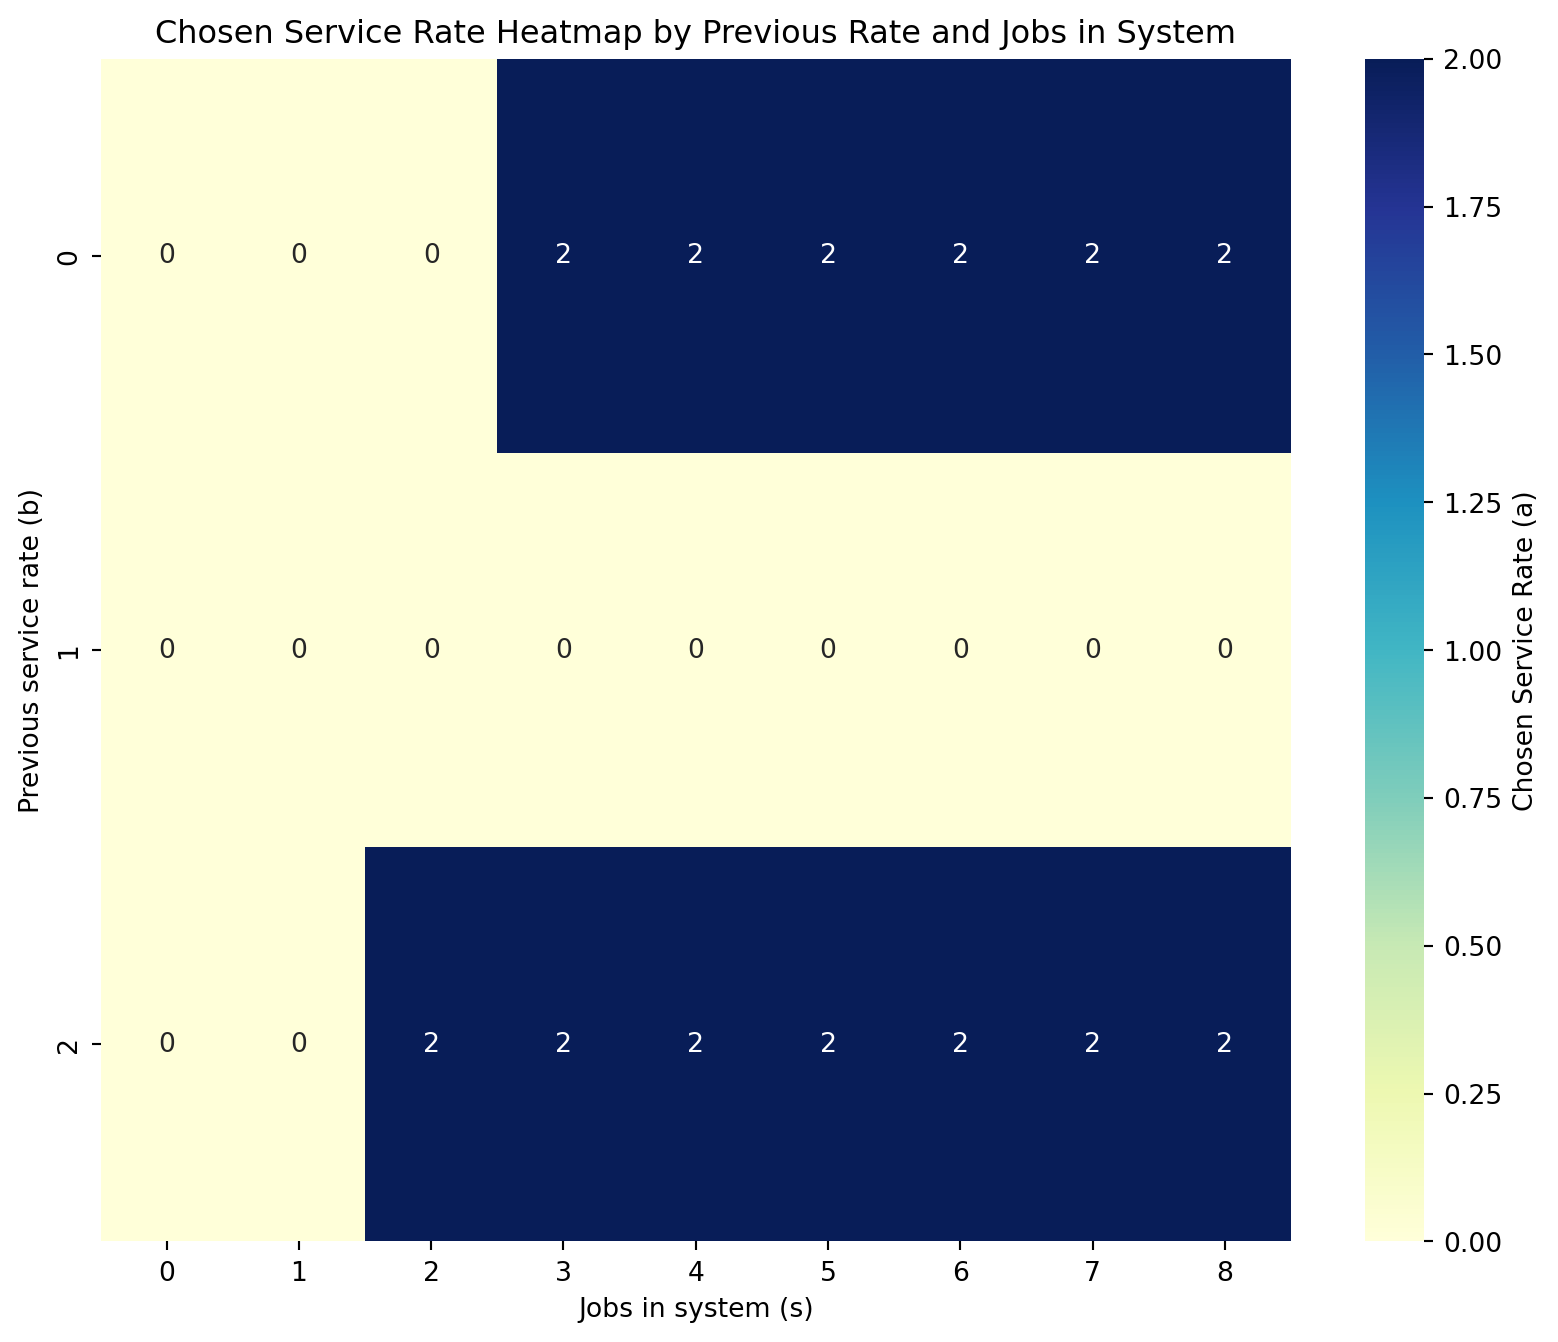

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp

# Create the solver
solver = pywraplp.Solver.CreateSolver('GLOP')
solver.SetTimeLimit(60000)  # Set time limit in milliseconds (60 seconds)

# Decision variables q_{(x,b),b'}: probability of choosing server state b' when state is (x,b)
q = {}
for x_i in X:
    for b in B:
        for b_prime in B:
            q[(x_i, b, b_prime)] = solver.NumVar(0.0, 1.0, f'q_{x_i}_{b}_{b_prime}')

# Objective: minimize the expected cost
objective = solver.Objective()
for x_i in X:
    for b in B:
        for a in B:
            objective.SetCoefficient(q[(x_i, b, a)], r(x_i, b, a))
objective.SetMinimization()

# Balance constraints
for x_j in X:
    for b_j in B:
        # Outflow: the sum of probabilities of choosing each action a in state (x_j, b_j)
        outflow = solver.Sum(q[(x_j, b_j, a)] for a in B)
        
        # Inflow: the weighted sum of transition probabilities for each incoming state-action pair
        inflow = solver.Sum(
            P(x_i, b_i, x_j, b_j, a) * q[(x_i, b_i, a)]
            for x_i in X for b_i in B for a in B
        )
        
        # Add the constraint that the inflow and outflow must be equal
        solver.Add(inflow == outflow)

# Probability constraint to ensure all probabilities sum to 1
solver.Add(solver.Sum(q[(x_i, b, a)] for x_i in X for b in B for a in B) == 1)

# Solve the problem
status = solver.Solve()

# Print the optimal solution and prepare DataFrame data
if status == pywraplp.Solver.OPTIMAL:
    opt_pol = []
    for x_i in X:
        for b in B:
            q_opt = []
            for a in B:
                q_value = q[(x_i, b, a)].solution_value()
                q_opt.append((a, q_value))
            # Find the service rate with the maximum q value
            best_action, best_q = max(q_opt, key=lambda item: item[1])
            opt_pol.append({
                'Jobs_in_System': x_i,
                'Previous_Rate': b,
                'Chosen_Rate': best_action,
                'Probability': best_q
            })
            print(f"If {x_i} jobs in the system and previous service rate was {b}:")
            print(f"      Use service rate {best_action} (q={best_q})")
else:
    print("No feasible solution found.")

# Convert opt_pol to a DataFrame
policy_df = pd.DataFrame(opt_pol)
display(policy_df)

# Sum of probabilities as a check
total_probability = policy_df['Probability'].sum()
print(f"Total probability sum: {total_probability}")

# Find maximum probability actions by (Jobs_in_System, Previous_Rate)
policy_max_df = policy_df.loc[policy_df.groupby(['Jobs_in_System', 'Previous_Rate'])['Probability'].idxmax()]

# Prepare data for heatmap
heatmap_data = policy_max_df.pivot(columns="Jobs_in_System", index="Previous_Rate", values="Chosen_Rate")

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Chosen Service Rate (a)'})
plt.title("Chosen Service Rate Heatmap by Previous Rate and Jobs in System")
plt.xlabel("Jobs in system (s)")
plt.ylabel("Previous service rate (b)")
plt.savefig("no_constraint.png", dpi=300, bbox_inches="tight", format="png")
plt.show()

#### Optimality criterion: average cost with service rate restriction

This solution applies the **service rate restriction** to the average cost model, limiting the usage of the highest service rate $b = 2$ while aiming to minimize the average cost per period.

**Solution Design:**

-   **State and Action Spaces, Transition Probabilities, and Reward Function**: Same as in the average cost model.

-   **Service Rate Restriction**:

    -   Similar to the previous solution, a constraint is added to limit the total probability of choosing service rate $a = 2$.

**Code Explanation:**

-   **Initialization, Decision Variables, Objective Function, and Balance Constraints**: Same as in the average cost model.

-   **Total Probability Constraint**: Ensures the probabilities sum to 1.


If 0 jobs in the system and previous service rate was 0:
      Use service rate 0 (q=0.003885354105247635)
If 0 jobs in the system and previous service rate was 1:
      Use service rate 1 (q=0.04958671232187846)
If 0 jobs in the system and previous service rate was 2:
      Use service rate 0 (q=-0.0)
If 1 jobs in the system and previous service rate was 0:
      Use service rate 0 (q=0.006893585699991022)
If 1 jobs in the system and previous service rate was 1:
      Use service rate 1 (q=0.10295033732486464)
If 1 jobs in the system and previous service rate was 2:
      Use service rate 0 (q=0.005440138186326211)
If 2 jobs in the system and previous service rate was 0:
      Use service rate 0 (q=0.005969355181582941)
If 2 jobs in the system and previous service rate was 1:
      Use service rate 1 (q=0.12197728507626432)
If 2 jobs in the system and previous service rate was 2:
      Use service rate 1 (q=0.01741306892417055)
If 3 jobs in the system and previous service rate was 0:


,Jobs_in_System,Previous_Rate,Chosen_Rate,Probability
0,0,0,0,0.003885
1,0,1,1,0.049587
2,0,2,0,-0.000000
3,1,0,0,0.006894
4,1,1,1,0.102950
5,1,2,0,0.005440
6,2,0,0,0.005969
7,2,1,1,0.121977
8,2,2,1,0.017413
9,3,0,1,0.003384


Total probability sum: 0.9791952958326499


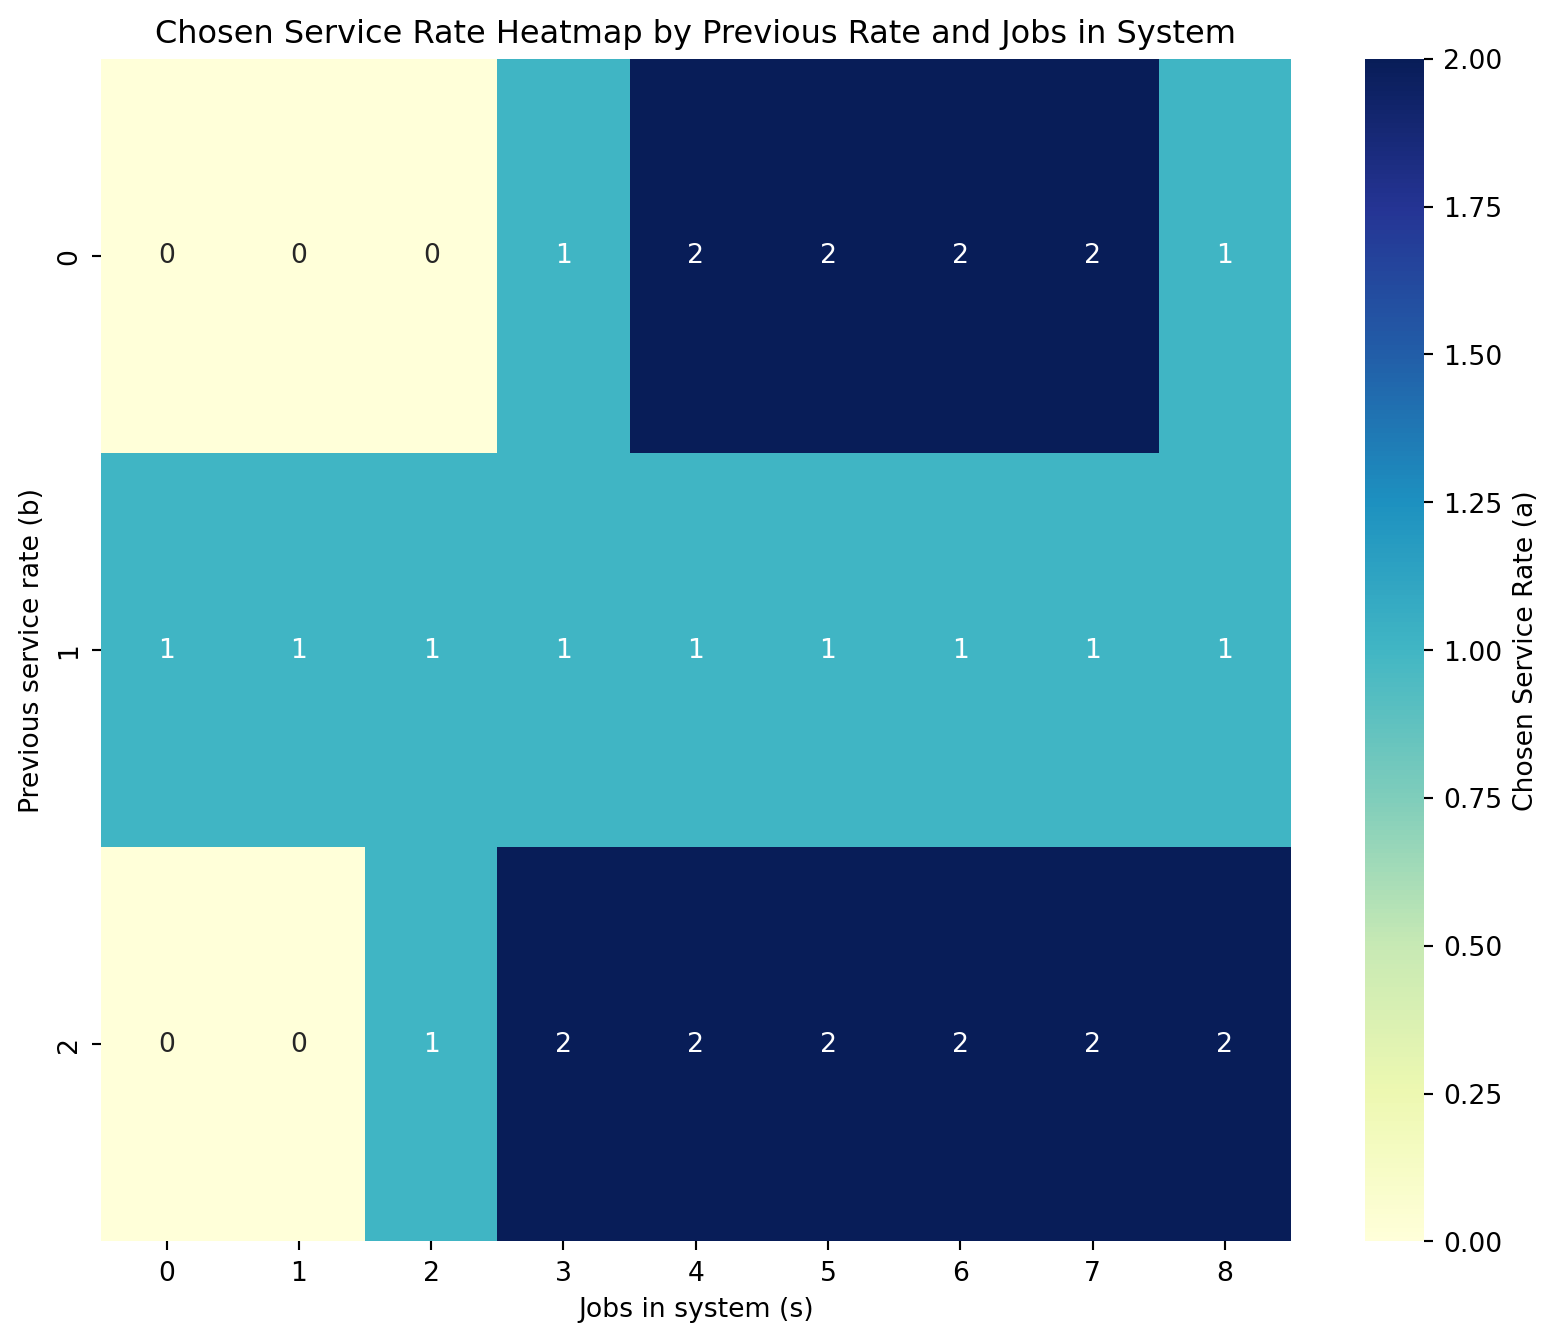

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp

# Create the solver
solver = pywraplp.Solver.CreateSolver('GLOP')
solver.SetTimeLimit(60000)  # Set time limit in milliseconds (60 seconds)

# Decision variables q_{(x,b),b'}: probability of choosing server state b' when state is (x,b)
q = {}
for x_i in X:
    for b in B:
        for b_prime in B:
            q[(x_i, b, b_prime)] = solver.NumVar(0.0, 1.0, f'q_{x_i}_{b}_{b_prime}')

# Objective: minimize the expected cost
objective = solver.Objective()
for x_i in X:
    for b in B:
        for a in B:
            objective.SetCoefficient(q[(x_i, b, a)], r(x_i, b, a))
objective.SetMinimization()

# Balance constraints
for x_j in X:
    for b_j in B:
        # Outflow: the sum of probabilities of choosing each action a in state (x_j, b_j)
        outflow = solver.Sum(q[(x_j, b_j, a)] for a in B)
        
        # Inflow: the weighted sum of transition probabilities for each incoming state-action pair
        inflow = solver.Sum(
            P(x_i, b_i, x_j, b_j, a) * q[(x_i, b_i, a)]
            for x_i in X for b_i in B for a in B
        )
        
        # Add the constraint that the inflow and outflow must be equal
        solver.Add(inflow == outflow)

# Probability constraint to ensure all probabilities sum to 1
solver.Add(solver.Sum(q[(x_i, b, a)] for x_i in X for b in B for a in B) == 1)

# Service rate restriction: Limit the probability of using server state b = 2 to 25%
service_rate_limit = solver.Sum(q[(x_i, 2, a)] for x_i in X for a in B)
solver.Add(service_rate_limit <= 0.25)

# Solve the problem
status = solver.Solve()

# Print the optimal solution and prepare data for visualization
if status == pywraplp.Solver.OPTIMAL:
    opt_pol = {'Jobs_in_System': [], 'Previous_Rate': [], 'Chosen_Rate': [], 'Probability': []}
    for x_i in X:
        for b in B:
            q_opt = []
            for a in B:
                q_value = q[(x_i, b, a)].solution_value()
                q_opt.append((a, q_value))
            # Find the service rate with the maximum q value
            best_action, best_q = max(q_opt, key=lambda item: item[1])
            opt_pol['Jobs_in_System'].append(x_i)
            opt_pol['Previous_Rate'].append(b)
            opt_pol['Chosen_Rate'].append(best_action)
            opt_pol['Probability'].append(best_q)
            print(f"If {x_i} jobs in the system and previous service rate was {b}:")
            print(f"      Use service rate {best_action} (q={best_q})")
else:
    print("No feasible solution found.")

# Convert opt_pol to a DataFrame
policy_df = pd.DataFrame(opt_pol)
display(policy_df)

# Sum of probabilities as a check
total_probability = policy_df['Probability'].sum()
print(f"Total probability sum: {total_probability}")

# Find the maximum probability actions by (Jobs_in_System, Previous_Rate) if needed
policy_max_df = policy_df.loc[policy_df.groupby(['Jobs_in_System', 'Previous_Rate'])['Probability'].idxmax()]

# Prepare data for heatmap
heatmap_data = policy_max_df.pivot(index="Previous_Rate", columns="Jobs_in_System", values="Chosen_Rate")

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Chosen Service Rate (a)'})
plt.title("Chosen Service Rate Heatmap by Previous Rate and Jobs in System")
plt.xlabel("Jobs in system (s)")
plt.ylabel("Previous service rate (b)")
plt.savefig("no_constraint.png", dpi=300, bbox_inches="tight", format="png")
plt.show()

**General Notes on the Code:**

-   **Solver Configuration**:
    -   All models use the OR-Tools `GLOP` linear solver.
    -   Time limits are set where necessary to prevent long computation times.
-   **Printing Results**:
    -   The code checks if an optimal solution is found.
    -   It iterates over all states and prints the optimal action(s) where the decision variable $x$ is positive, indicating the action(s) to take in each state.